#### __LIBRARIES__

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#### __LOAD DATASET__

In [2]:
df = pd.read_csv("WSdata.csv")
df.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,192.167.7.43,192.167.7.45,ICMP,98,"Echo (ping) request id=0x35a7, seq=119/30464,..."
1,2,0.160909,192.167.7.43,192.167.7.45,UDP,162,8130 > 12345 Len=120
2,3,1.024022,192.167.7.43,192.167.7.45,ICMP,98,"Echo (ping) request id=0x35a7, seq=120/30720,..."
3,4,1.161161,192.167.7.43,192.167.7.45,UDP,162,8131 > 12345 Len=120
4,5,2.048007,192.167.7.43,192.167.7.45,ICMP,98,"Echo (ping) request id=0x35a7, seq=121/30976,..."


#### __EDA__

- __Useless Column Drop__

In [3]:
df = df.drop(columns=["No."], errors="ignore")
df.head()

,Time,Source,Destination,Protocol,Length,Info
0,0.000000,192.167.7.43,192.167.7.45,ICMP,98,"Echo (ping) request id=0x35a7, seq=119/30464,..."
1,0.160909,192.167.7.43,192.167.7.45,UDP,162,8130 > 12345 Len=120
2,1.024022,192.167.7.43,192.167.7.45,ICMP,98,"Echo (ping) request id=0x35a7, seq=120/30720,..."
3,1.161161,192.167.7.43,192.167.7.45,UDP,162,8131 > 12345 Len=120
4,2.048007,192.167.7.43,192.167.7.45,ICMP,98,"Echo (ping) request id=0x35a7, seq=121/30976,..."


- __Dataset Overview__

In [4]:
print("Dataset Shape:", df.shape)

Dataset Shape: (19380, 6)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19380 entries, 0 to 19379
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         19380 non-null  float64
 1   Source       19380 non-null  object 
 2   Destination  19380 non-null  object 
 3   Protocol     19380 non-null  object 
 4   Length       19380 non-null  int64  
 5   Info         19379 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 908.6+ KB


- __Duplicates & Missing Values__

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.isnull().sum().sum()

np.int64(1)

In [8]:
null_before	= df.isnull().sum().sum()
df.dropna(inplace=True)
print(f"Null values removed: {null_before}")

Null values removed: 1


- __Protocol Analysis__

In [9]:
print(f"Total unique protocols: {df['Protocol'].nunique()}\n")
protocol_counts = df['Protocol'].value_counts()
print(protocol_counts)

Total unique protocols: 9

Protocol
TCP        16744
TLSv1.2     1819
ICMP         418
UDP          289
ARP           50
TLSv1.3       31
NBNS          21
DNS            6
BROWSER        1
Name: count, dtype: int64


- __LENGTH ANALYSIS__


Packet Length Statistics:
count    19379.000000
mean      1170.597193
std        604.233574
min         42.000000
25%       1239.000000
50%       1514.000000
75%       1514.000000
max       2878.000000
Name: Length, dtype: float64


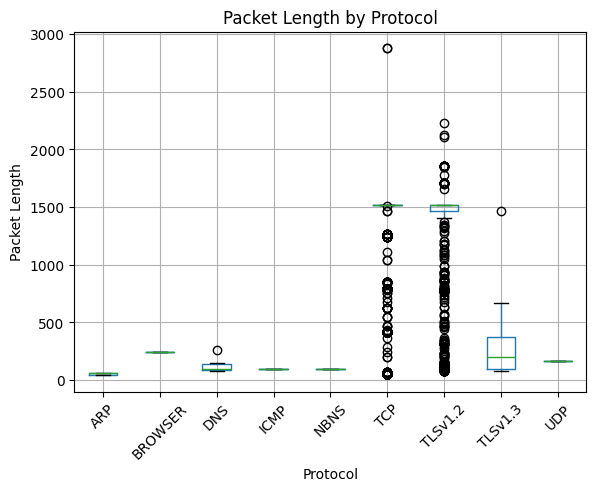

In [10]:
print("\nPacket Length Statistics:")
print(df["Length"].describe())

df.boxplot(column="Length", by="Protocol", rot=45)
plt.title("Packet Length by Protocol")
plt.suptitle("")
plt.xlabel("Protocol")
plt.ylabel("Packet Length")
plt.show()


#### __DATASET LABELLING__

In [11]:
def label_traffic(row):
    malicious_protocols = {'ICMP', 'SSH', 'MDNS', 'Telenet', 'TLSv1.2'} 
    malicious_keywords = {'cipher', 'syn', 'fin', 'psh', }
				# Check: malicious protocols
    if row['Protocol'] in malicious_protocols:
        return 1

    # Check: malicious keywords
    if any(keyword in str(row['Info']).lower() for keyword in malicious_keywords):
        return 1

    # otherwise, normal
    return 0

# Apply labeling function to dataset
df['Label'] = df.apply(label_traffic, axis=1)
df.head()

,Time,Source,Destination,Protocol,Length,Info,Label
0,0.000000,192.167.7.43,192.167.7.45,ICMP,98,"Echo (ping) request id=0x35a7, seq=119/30464,...",1
1,0.160909,192.167.7.43,192.167.7.45,UDP,162,8130 > 12345 Len=120,0
2,1.024022,192.167.7.43,192.167.7.45,ICMP,98,"Echo (ping) request id=0x35a7, seq=120/30720,...",1
3,1.161161,192.167.7.43,192.167.7.45,UDP,162,8131 > 12345 Len=120,0
4,2.048007,192.167.7.43,192.167.7.45,ICMP,98,"Echo (ping) request id=0x35a7, seq=121/30976,...",1


#### __ENCODING & NORMALIZATION__

In [12]:
protocol_encoder = LabelEncoder()
df['Protocol_Encoded'] = protocol_encoder.fit_transform(df['Protocol'])

scaler = MinMaxScaler()
df[['Time_Normalized', 'Length_Normalized']] = scaler.fit_transform(df[['Time', 'Length']])

df.head()

,Time,Source,Destination,Protocol,Length,Info,Label,Protocol_Encoded,Time_Normalized,Length_Normalized
0,0.000000,192.167.7.43,192.167.7.45,ICMP,98,"Echo (ping) request id=0x35a7, seq=119/30464,...",1,3,0.000000,0.019746
1,0.160909,192.167.7.43,192.167.7.45,UDP,162,8130 > 12345 Len=120,0,8,0.000555,0.042313
2,1.024022,192.167.7.43,192.167.7.45,ICMP,98,"Echo (ping) request id=0x35a7, seq=120/30720,...",1,3,0.003534,0.019746
3,1.161161,192.167.7.43,192.167.7.45,UDP,162,8131 > 12345 Len=120,0,8,0.004007,0.042313
4,2.048007,192.167.7.43,192.167.7.45,ICMP,98,"Echo (ping) request id=0x35a7, seq=121/30976,...",1,3,0.007067,0.019746


In [13]:
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(protocol_encoder, 'protocol_encoder.pkl')

['protocol_encoder.pkl']

In [14]:
print(df['Label'].value_counts())

Label
0    16574
1     2805
Name: count, dtype: int64


In [15]:
# Select features and labels
features = ['Protocol_Encoded', 'Time_Normalized', 'Length_Normalized']
X = df[features]
y = df['Label']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
models = {
    "logistic regression": LogisticRegression(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "TabNet": TabNetClassifier(),
    "LightGBM": LGBMClassifier()
}

c:\Users\DeLL\Desktop\Network-Intrusion-Detection-Using-Wireshark\venv\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [18]:
# Train and evaluate each model
for name, model in models.items():
    # Convert DataFrames to NumPy arrays for models that require it
    model.fit(X_train.values, y_train.values)
    
    y_pred = model.predict(X_test.values)
    
    # Print model performance with better readability
    print("="*40)  # Adds a separator line
    print(f"{name} Model Performance:\n")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_pred))
    print(" "*40)

logistic regression Model Performance:

Accuracy: 0.8415892672858617
Precision: 0.011764705882352941
Recall: 0.0011933174224343676
F1-score: 0.0021668472372697724
ROC AUC: 0.4921561442417638
                                        
CatBoost Model Performance:

Accuracy: 0.9943240454076367
Precision: 0.9987608426270136
Recall: 0.9618138424821002
F1-score: 0.9799392097264438
ROC AUC: 0.9808064389259377
                                        


c:\Users\DeLL\Desktop\Network-Intrusion-Detection-Using-Wireshark\venv\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.31663 |  0:00:04s
epoch 1  | loss: 0.07701 |  0:00:07s
epoch 2  | loss: 0.04721 |  0:00:10s
epoch 3  | loss: 0.03945 |  0:00:13s
epoch 4  | loss: 0.03779 |  0:00:17s
epoch 5  | loss: 0.04187 |  0:00:21s
epoch 6  | loss: 0.03581 |  0:00:26s
epoch 7  | loss: 0.0436  |  0:00:28s
epoch 8  | loss: 0.03578 |  0:00:30s
epoch 9  | loss: 0.03192 |  0:00:32s
epoch 10 | loss: 0.03356 |  0:00:34s
epoch 11 | loss: 0.03034 |  0:00:36s
epoch 12 | loss: 0.03014 |  0:00:38s
epoch 13 | loss: 0.03505 |  0:00:39s
epoch 14 | loss: 0.0335  |  0:00:41s
epoch 15 | loss: 0.03229 |  0:00:43s
epoch 16 | loss: 0.03138 |  0:00:46s
epoch 17 | loss: 0.03153 |  0:00:48s
epoch 18 | loss: 0.03051 |  0:00:49s
epoch 19 | loss: 0.02955 |  0:00:51s
epoch 20 | loss: 0.03038 |  0:00:53s
epoch 21 | loss: 0.02978 |  0:00:55s
epoch 22 | loss: 0.03085 |  0:00:57s
epoch 23 | loss: 0.02974 |  0:00:59s
epoch 24 | loss: 0.04075 |  0:01:01s
epoch 25 | loss: 0.03496 |  0:01:04s
epoch 26 | loss: 0.03212 |  0:01:06s
e

c:\Users\DeLL\Desktop\Network-Intrusion-Detection-Using-Wireshark\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Model Performance:

Accuracy: 0.9943240454076367
Precision: 0.9975278121137207
Recall: 0.9630071599045346
F1-score: 0.9799635701275046
ROC AUC: 0.9813026153220423
                                        


In [19]:
import joblib

# Save CatBoost
joblib.dump(models["CatBoost"], "catboost_model.pkl")

# Save LightGBM
joblib.dump(models["LightGBM"], "lightgbm_model.pkl")

['lightgbm_model.pkl']